In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Omniglot
from torchvision import transforms

In [49]:
class CNNOmniglot(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(    
            # 1 x 105 x 105
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64 x 52 x 52
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64 x 26 x 26
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 64 x 13 x 13
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),  
            # 64 x 7 x 7
        )

        self.dec = nn.Sequential(
            # 64 x 5 x 5
            nn.ConvTranspose2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, 3, 2, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, 3, 2, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.enc(x)
        return self.dec(x)

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

trainset = Omniglot(root='~/data',  background=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)
testset = Omniglot(root='~/data', background=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=24)

print(len(train_dl), len(test_dl))

100%|██████████████████████████████████████| 9464212/9464212 [00:00<00:00, 11160824.39it/s]


Extracting /home/khoidh/data/omniglot-py/images_background.zip to /home/khoidh/data/omniglot-py


100%|██████████████████████████████████████| 6462886/6462886 [00:00<00:00, 10696475.85it/s]


Extracting /home/khoidh/data/omniglot-py/images_evaluation.zip to /home/khoidh/data/omniglot-py
302 206


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

epochs = 10

model = CNNOmniglot().to(device)

optimizer = Adam(model.parameters(), lr = 0.001)

scheduler = CosineAnnealingLR(optimizer, epochs)

loss_fn = nn.MSELoss()

In [52]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img = model(train_img)        
        train_loss = loss_fn(gen_img, train_img)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img = model(valid_img)

            valid_loss = loss_fn(gen_img, valid_img)

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|████████████████████████████████████████████████████| 206/206 [00:02<00:00, 72.14it/s]


Epoch: 0 - TrainLoss: 3.0871990642800236 - ValidLoss: 3.065300824572739


100%|████████████████████████████████████████████████████| 206/206 [00:02<00:00, 71.32it/s]


Epoch: 1 - TrainLoss: 3.0824984327846807 - ValidLoss: 3.0637669621162043


100%|████████████████████████████████████████████████████| 206/206 [00:02<00:00, 72.34it/s]


Epoch: 2 - TrainLoss: 3.0803523182079493 - ValidLoss: 3.0606900233666874


100%|████████████████████████████████████████████████████| 206/206 [00:02<00:00, 70.02it/s]


Epoch: 3 - TrainLoss: 3.0790035756218512 - ValidLoss: 3.0596128297083585


100%|████████████████████████████████████████████████████| 206/206 [00:02<00:00, 71.90it/s]


Epoch: 4 - TrainLoss: 3.0780780181190037 - ValidLoss: 3.0585459991566184


100%|████████████████████████████████████████████████████| 206/206 [00:02<00:00, 68.95it/s]


Epoch: 5 - TrainLoss: 3.077530946163152 - ValidLoss: 3.057868927427866


100%|████████████████████████████████████████████████████| 206/206 [00:02<00:00, 69.23it/s]


Epoch: 6 - TrainLoss: 3.0770386725861507 - ValidLoss: 3.057235166864488


100%|████████████████████████████████████████████████████| 206/206 [00:02<00:00, 69.03it/s]


Epoch: 7 - TrainLoss: 3.0764588172862073 - ValidLoss: 3.058800851257102


100%|████████████████████████████████████████████████████| 206/206 [00:02<00:00, 69.18it/s]


Epoch: 8 - TrainLoss: 3.076077041247033 - ValidLoss: 3.0566604322600135


100%|████████████████████████████████████████████████████| 206/206 [00:02<00:00, 71.57it/s]

Epoch: 9 - TrainLoss: 3.0757080119177207 - ValidLoss: 3.0563716575937363


100%|██████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.85it/s]


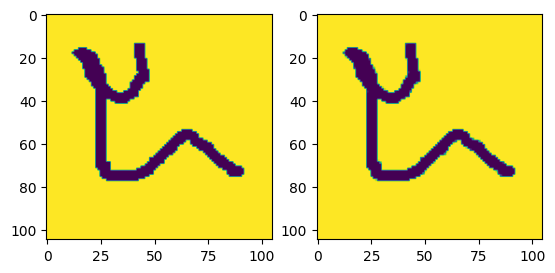

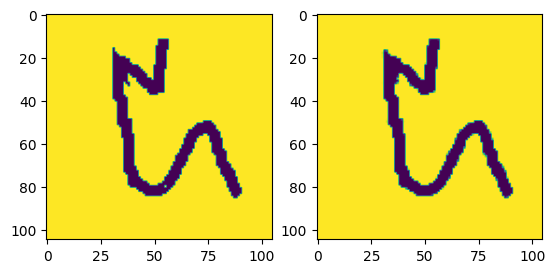

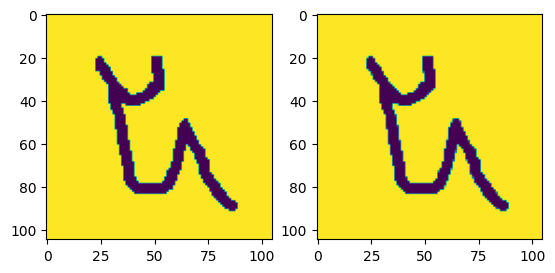

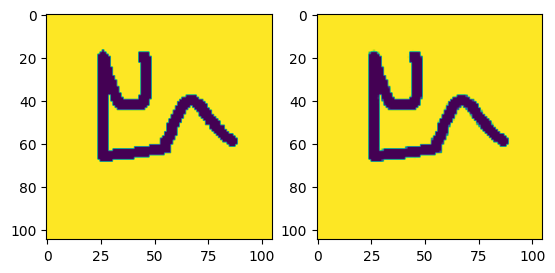

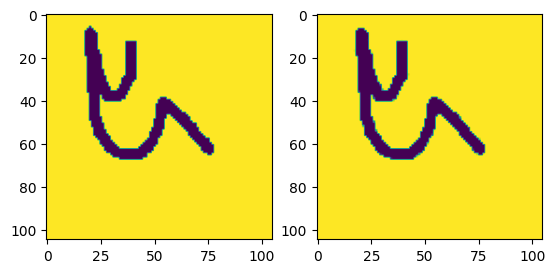

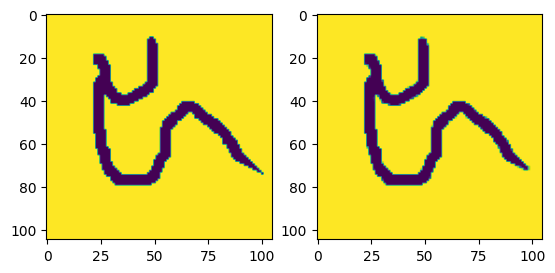

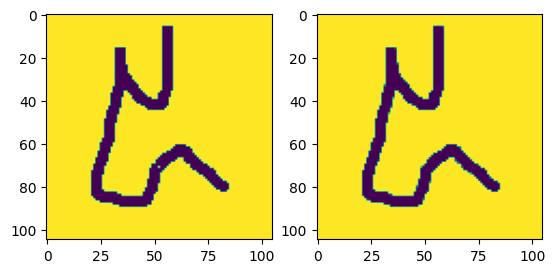

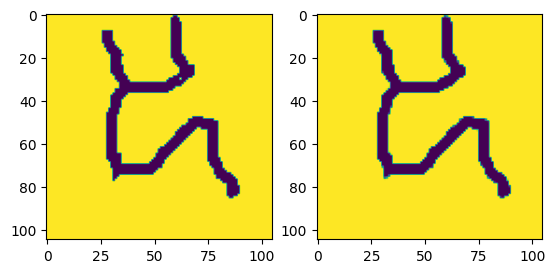

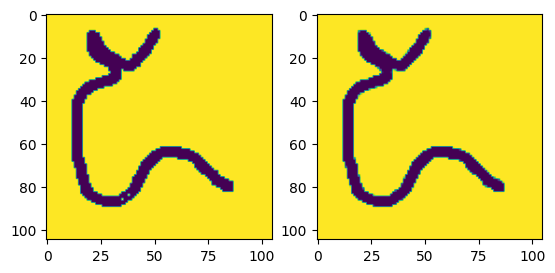

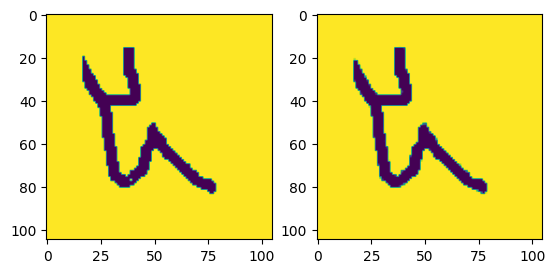

In [53]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())